In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score, calinski_harabasz_score


In [2]:
# Load the Iris dataset
data = load_iris()
X = data.data
y = data.target

# Convert to DataFrame for easier handling
df = pd.DataFrame(X, columns=data.feature_names)
df['target'] = y
print(df.head())


   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0       0  
1       0  
2       0  
3       0  
4       0  


In [3]:
# Create a preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    # Add more preprocessing steps here if needed
])

# Apply the preprocessing pipeline
X_scaled = preprocessing_pipeline.fit_transform(X)


In [4]:
# Define the t-SNE model
tsne = TSNE(random_state=42)

# Define the parameter grid
param_grid = {
    'perplexity': [5, 30, 50],
    'n_iter': [300, 500, 1000],
    'learning_rate': [10, 100, 500]
}

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(tsne, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_scaled)

# Best parameters
print(f"Best t-SNE parameters: {grid_search.best_params_}")


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/

Best t-SNE parameters: {'learning_rate': 10, 'n_iter': 300, 'perplexity': 5}


In [5]:
# Apply PCA
pca = PCA(n_components=3)  # 3D PCA
X_pca = pca.fit_transform(X_scaled)

# Apply t-SNE with best parameters
tsne_best = TSNE(**grid_search.best_params_, random_state=42)
X_tsne = tsne_best.fit_transform(X_scaled)


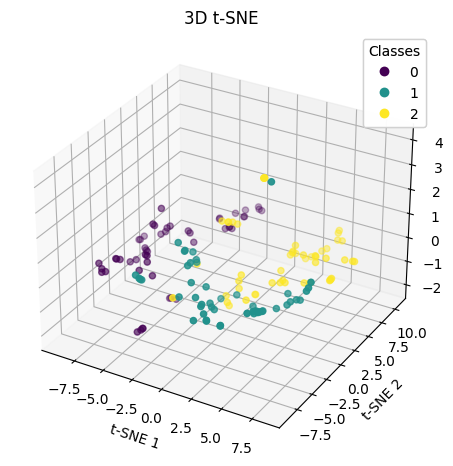

In [10]:
# Apply t-SNE with 3 components
tsne_best = TSNE(n_components=3, **grid_search.best_params_, random_state=42)
X_tsne = tsne_best.fit_transform(X_scaled)

# 3D t-SNE Visualization
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(122, projection='3d')
scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=y, cmap='viridis')
legend2 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend2)
ax.set_title('3D t-SNE')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3')

plt.show()


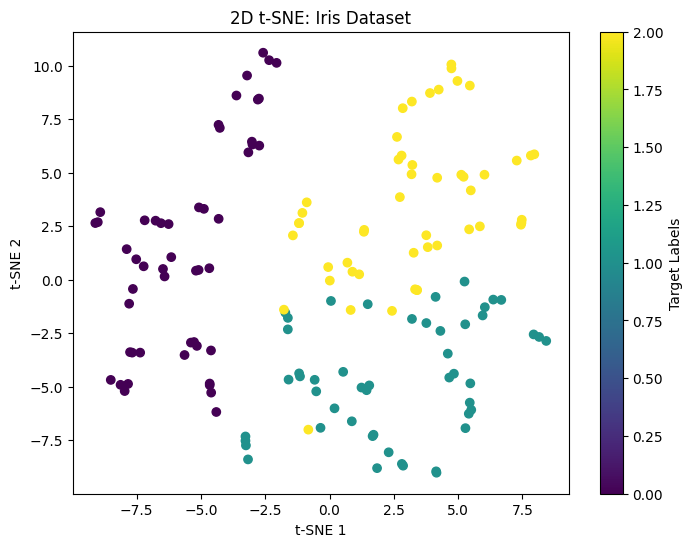

In [11]:
# 2D t-SNE Visualization
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('2D t-SNE: Iris Dataset')
plt.colorbar(label='Target Labels')
plt.show()


In [12]:
# Silhouette Score
sil_pca = silhouette_score(X_pca, y)
sil_tsne = silhouette_score(X_tsne, y)

# Calinski-Harabasz Index
ch_pca = calinski_harabasz_score(X_pca, y)
ch_tsne = calinski_harabasz_score(X_tsne, y)

print(f'Silhouette Score (PCA): {sil_pca}')
print(f'Silhouette Score (t-SNE): {sil_tsne}')
print(f'Calinski-Harabasz Index (PCA): {ch_pca}')
print(f'Calinski-Harabasz Index (t-SNE): {ch_tsne}')


Silhouette Score (PCA): 0.3860576068067479
Silhouette Score (t-SNE): 0.3355792462825775
Calinski-Harabasz Index (PCA): 194.82575375410423
Calinski-Harabasz Index (t-SNE): 92.03468490060273


In [13]:
from sklearn.cluster import MiniBatchKMeans

# Use MiniBatchKMeans for larger datasets
batch_size = 100  # Adjust based on dataset size
mini_tsne = TSNE(n_components=2, method='exact', random_state=42)
mini_kmeans = MiniBatchKMeans(batch_size=batch_size)

X_mini_tsne = mini_tsne.fit_transform(X_scaled)


In [15]:
from sklearn.base import BaseEstimator, TransformerMixin

class DimensionalityReductionPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, method='pca', n_components=2, **kwargs):
        self.method = method
        self.n_components = n_components
        self.kwargs = kwargs
        self.model = None

    def fit(self, X, y=None):
        if self.method == 'pca':
            self.model = PCA(n_components=self.n_components, **self.kwargs)
            self.model.fit(X)
        elif self.method == 'tsne':
            self.model = TSNE(n_components=self.n_components, **self.kwargs)
            # t-SNE will fit and transform in the same step
            X_reduced = self.model.fit_transform(X)
            return X_reduced
        return self

    def transform(self, X, y=None):
        if self.method == 'pca':
            return self.model.transform(X)
        elif self.method == 'tsne':
            # Since t-SNE does not support transform, we return the result of fit_transform
            X_reduced = self.model.fit_transform(X)
            return X_reduced

# Example Usage
dr_pipeline = DimensionalityReductionPipeline(method='tsne', n_components=2, perplexity=30, n_iter=1000)
X_reduced = dr_pipeline.fit(X_scaled)


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Model training
model = RandomForestClassifier(random_state=42)
scores = cross_val_score(model, X_reduced, y, cv=5)
print(f'Cross-validation accuracy: {np.mean(scores)}')


Cross-validation accuracy: 0.9733333333333334
